使用ResNet34对QuickDraw进行分类
===

In [1]:
import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

# 1.全局设置

In [3]:
RANDOM_SEED = 1
LEARNING_RATE = 0.001
BATCH_SIZE = 128
NUM_EPOCHS = 10

# Architecture
NUM_FEATURES = 28*28
NUM_CLASSES = 10

# Other
DEVICE = "cuda:0"
GRAYSCALE = True

DATA_ROOT=os.path.join('/input', 'QuickDraw')

(28, 28)


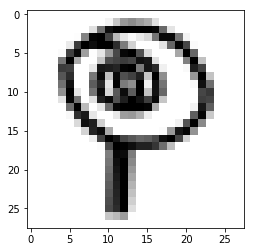

In [4]:
df = pd.read_csv(os.path.join(DATA_ROOT, 'quickdraw_png_set1_train.csv'), index_col=0)
df.head()

main_dir = os.path.join(DATA_ROOT, 'images')

img = Image.open(os.path.join(main_dir, df.index[99]))
img = np.asarray(img, dtype=np.uint8)
print(img.shape)
plt.imshow(np.array(img), cmap='binary')

# 2.导入数据

In [5]:
class QuickdrawDataset(Dataset):
    """Custom Dataset for loading Quickdraw images"""

    def __init__(self, txt_path, img_dir, transform=None):
    
        df = pd.read_csv(txt_path, sep=",", index_col=0)
        self.img_dir = img_dir
        self.txt_path = txt_path
        self.img_names = df.index.values
        self.y = df['Label'].values
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir,
                                      self.img_names[index]))
        
        if self.transform is not None:
            img = self.transform(img)
        
        label = self.y[index]
        return img, label

    def __len__(self):
        return self.y.shape[0]

In [6]:
BATCH_SIZE = 128

custom_transform = transforms.Compose([transforms.ToTensor()])

train_dataset = QuickdrawDataset(txt_path=os.path.join(DATA_ROOT, 'quickdraw_png_set1_train.csv'),
                                 img_dir=os.path.join(DATA_ROOT, 'images'),
                                 transform=custom_transform)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=4) 


valid_dataset = QuickdrawDataset(txt_path=os.path.join(DATA_ROOT, 'quickdraw_png_set1_train.csv'),
                                 img_dir=os.path.join(DATA_ROOT, 'images'),
                                transform=custom_transform)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=4) 



test_dataset = QuickdrawDataset(txt_path=os.path.join(DATA_ROOT, 'quickdraw_png_set1_train.csv'),
                                 img_dir=os.path.join(DATA_ROOT, 'images'),
                                transform=custom_transform)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=4) 

# 3.模型

In [7]:
device = torch.device(DEVICE if torch.cuda.is_available() else "cpu")
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out




class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        # because MNIST is already 1x1 here:
        # disable avg pooling
        #x = self.avgpool(x)
        
        x = x.view(x.size(0), -1)
        logits = self.fc(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas



def resnet34(num_classes):
    """Constructs a ResNet-34 model."""
    model = ResNet(block=BasicBlock, 
                   layers=[3, 4, 6, 3],
                   num_classes=NUM_CLASSES,
                   grayscale=GRAYSCALE)
    return model

In [8]:
torch.manual_seed(RANDOM_SEED)
model = resnet34(NUM_CLASSES)
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# 4.训练

In [9]:
def compute_accuracy(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100
    

start_time = time.time()
for epoch in range(NUM_EPOCHS):
    
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 500:
            print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                   %(epoch+1, NUM_EPOCHS, batch_idx, 
                     len(train_loader), cost))

        

    model.eval()
    with torch.set_grad_enabled(False): # save memory during inference
        print('Epoch: %03d/%03d | Train: %.3f%% | Validation: %.3f%%' % (
              epoch+1, NUM_EPOCHS, 
              compute_accuracy(model, train_loader, device=DEVICE),
              compute_accuracy(model, valid_loader, device=DEVICE)))
        
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/010 | Batch 0000/8290 | Cost: 2.7658
Epoch: 001/010 | Batch 0500/8290 | Cost: 0.4341
Epoch: 001/010 | Batch 1000/8290 | Cost: 0.3806
Epoch: 001/010 | Batch 1500/8290 | Cost: 0.4194
Epoch: 001/010 | Batch 2000/8290 | Cost: 0.3328
Epoch: 001/010 | Batch 2500/8290 | Cost: 0.4841
Epoch: 001/010 | Batch 3000/8290 | Cost: 0.4001
Epoch: 001/010 | Batch 3500/8290 | Cost: 0.1948
Epoch: 001/010 | Batch 4000/8290 | Cost: 0.3536
Epoch: 001/010 | Batch 4500/8290 | Cost: 0.2633
Epoch: 001/010 | Batch 5000/8290 | Cost: 0.2803
Epoch: 001/010 | Batch 5500/8290 | Cost: 0.3563
Epoch: 001/010 | Batch 6000/8290 | Cost: 0.2477
Epoch: 001/010 | Batch 6500/8290 | Cost: 0.3710
Epoch: 001/010 | Batch 7000/8290 | Cost: 0.2519
Epoch: 001/010 | Batch 7500/8290 | Cost: 0.2810
Epoch: 001/010 | Batch 8000/8290 | Cost: 0.2190
Epoch: 001/010 | Train: 93.225% | Validation: 93.225%
Time elapsed: 15.07 min
Epoch: 002/010 | Batch 0000/8290 | Cost: 0.2471
Epoch: 002/010 | Batch 0500/8290 | Cost: 0.2490
Epoch: 002

Epoch: 010/010 | Batch 2000/8290 | Cost: 0.0860
Epoch: 010/010 | Batch 2500/8290 | Cost: 0.0192
Epoch: 010/010 | Batch 3000/8290 | Cost: 0.0916
Epoch: 010/010 | Batch 3500/8290 | Cost: 0.1194
Epoch: 010/010 | Batch 4000/8290 | Cost: 0.0816
Epoch: 010/010 | Batch 4500/8290 | Cost: 0.0585
Epoch: 010/010 | Batch 5000/8290 | Cost: 0.0901
Epoch: 010/010 | Batch 5500/8290 | Cost: 0.0681
Epoch: 010/010 | Batch 6000/8290 | Cost: 0.1458
Epoch: 010/010 | Batch 6500/8290 | Cost: 0.0787
Epoch: 010/010 | Batch 7000/8290 | Cost: 0.1260
Epoch: 010/010 | Batch 7500/8290 | Cost: 0.1415
Epoch: 010/010 | Batch 8000/8290 | Cost: 0.1003
Epoch: 010/010 | Train: 97.867% | Validation: 97.867%
Time elapsed: 112.84 min
Total Training Time: 112.84 min


# 5.评估

In [10]:
with torch.set_grad_enabled(False): # save memory during inference
    print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader, device=DEVICE)))

Test accuracy: 97.87%


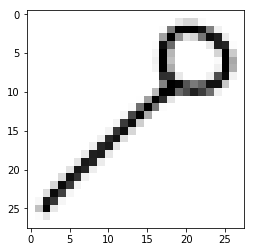

In [11]:
for batch_idx, (features, targets) in enumerate(test_loader):

    features = features
    targets = targets
    break
    
    
nhwc_img = np.transpose(features[5], axes=(1, 2, 0))
nhw_img = np.squeeze(nhwc_img.numpy(), axis=2)
plt.imshow(nhw_img, cmap='Greys');

In [12]:
model.eval()
logits, probas = model(features.to(device)[0, None])
print('Probability Washing Machine %.2f%%' % (probas[0][4]*100))

Probability Washing Machine 0.00%
